# Grad-CAM visualisation
This notebook is used to provide visual explanation for CNN predictions, calculating heatmap of regions, that are most important for specific final prediction.

I implemented two methods, Grad-CAM and guided Grad-CAM. Guided Grad-CAM should provide better prediction explanation as it uses guided backpropagation to focus only on gradients, that contribute positively to the final prediction.

Both methods are implemented inside ***utils.py*** with detailed descriptions.

In [4]:
import tensorflow as tf
import pandas as pd
import numpy as np
import cv2

import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
from utils import *
from image_preprocessing import *

# Constants

In [3]:
BASE_NAME = 'ResNet50' # Name of Keras applications architecture to be used as a base
WEIGHTS = '../models/ResNet50_avg_imagenet_clahe_2_best.h5' # Weights to be loaded in chosen model
INPUT_SHAPE = (224, 224, 3) # CNN model input shape
TARGET_SIZE = (224, 224) # Image target size, must match the model input

# Build model and load weights obtained from training

The choice of model and weights is not limited, Grad-CAM methods are universal

In [6]:
resNet = build_model(base_name=BASE_NAME,
                     weights=WEIGHTS,
                     shape=INPUT_SHAPE,
                     name='ResNet50',
                     pooling='avg')

Loaded weights from ../models/ResNet50_avg_imagenet_clahe_2_best.h5


# Setup

In [24]:
DATASET_PATH = '../datasets/tvt_detailed_paths.csv' # Path to csv file with dataset information (train-valid-test split)
DATASET_DIR = '../datasets/original/' # Specify directory with dataset you want to use

# Load desired portion of the dataset
df = get_dataframe('SHOULDER', 'test', DATASET_PATH)

def get_rand_positive_img(apply_clahe=False, clip=2, apply_eq_hist=False, normalize=True):
    """
    Returns one positive image from created dataframe at random, optionally applying selected preprocessing functions to
    match preprocessing used during training of model created earlier
    
    Parameters
    ----------
    apply_clahe: bool
        Whether to apply clahe or not
    clip: float
        Clip limit parameter for clahe function
    apply_eq_hist: bool
        Whether to apply histogram equalization or not
    normalize: bool
        Whether to normalize pixel values between [0, 1] or not
    
    Returns
    -------
    Image after selected preprocessing methods resized to desired size
    """
    rand_path = DATASET_DIR + df.loc[df.label=='positive'].sample(n=1).filepath.item()
    print('Path to random image:', rand_path)
    img = cv2.imread(rand_path)
    
    if apply_clahe:
        img = clahe(img, clip)
    if apply_eq_hist:
        img = eq_hist(img)
    
    img = cv2.resize(img, TARGET_SIZE)
    
    if normalize:
        img = img * 1./255
    return img

# Run Grad-CAM

Path to random image: ../datasets/original/MURA-v1.1/test/XR_SHOULDER/patient01350/study1_positive/image3.png
Prediction output: tf.Tensor([0.895031], shape=(1,), dtype=float32)


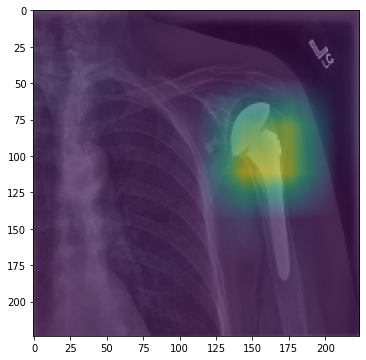

In [25]:
# Get random image with selected preprocessing
image = get_rand_positive_img(apply_clahe=True,
                     clip=2,
                     apply_eq_hist=False,
                     normalize=True)

# Select which Grad-CAM method you wish to use, it returns heatmap that will be plotted on top of predicted image
heatmap = guided_grad_cam(image, resNet)
# heatmap = guided_grad_cam(image, resNet)

fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(image)
ax.imshow(heatmap, alpha=0.5)
plt.show()